In [521]:
import pandas as pd
import numpy as np
import flwr as fl
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import DirichletPartitioner, IidPartitioner
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from flwr.common import ndarrays_to_parameters, parameters_to_ndarrays
from sklearn.metrics import accuracy_score, log_loss, precision_score, recall_score
from common_fun import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from collections import OrderedDict

In [522]:
IID_SENARIO = False
NUM_CLIENTS = 6

In [523]:
if IID_SENARIO:
    partitions = FederatedDataset(
        dataset="scikit-learn/adult-census-income",
        partitioners={
            "train": IidPartitioner(num_partitions=NUM_CLIENTS),
        }
    )
else:
    partitions = FederatedDataset(
        dataset="scikit-learn/adult-census-income",
        partitioners={"train": DirichletPartitioner(num_partitions=NUM_CLIENTS, partition_by="income", alpha=1)}
    )

print("Number of samples per Client:")
show_num_samples_per_client(partitions, NUM_CLIENTS)

Number of samples per Client:
Client 0 → 8265 samples
Client 1 → 10049 samples
Client 2 → 6682 samples
Client 3 → 1977 samples
Client 4 → 320 samples
Client 5 → 5268 samples


Data distribution for non-IID partitions:


c:\Users\prem2\miniconda3\envs\dataAnSc\Lib\site-packages\flwr_datasets\metrics\utils.py:130: UserWarning: The verbose names can not be established. The column specified by 'column_name' needs to be of type 'ClassLabel' to create a verbose names. The available names will used.
  warnings.warn(


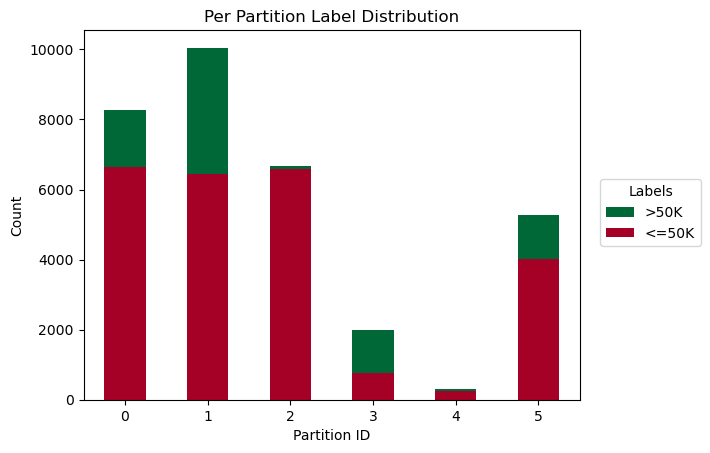

In [524]:
print("Data distribution for non-IID partitions:")
showDataDist(partitions, "income")

In [525]:
part_features = {}
client_partitions = []

for i in range(NUM_CLIENTS):
    part = preprocess_data(partitions.load_partition(i).to_pandas())
    client_partitions.append(part)
    print(f"Partition {i} shape: {part.shape}")
    part_features[f"Partition {i+1}"] = part.shape[1] # Exclude label column

Partition 0 shape: (7670, 25)
Partition 1 shape: (9371, 25)
Partition 2 shape: (6106, 25)
Partition 3 shape: (1841, 23)
Partition 4 shape: (301, 23)
Partition 5 shape: (4873, 25)


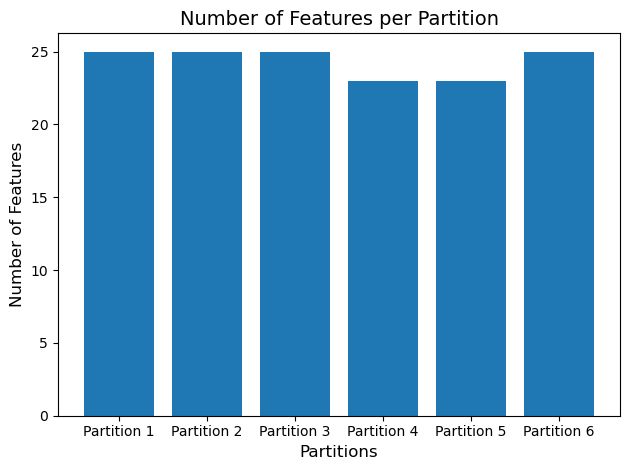

In [526]:
plot_number_of_features(part_features)

In [527]:
all_columns = set()
for df in client_partitions:
    all_columns.update(df.columns)


all_columns = sorted(all_columns)


normalized_partitions = []
for df in client_partitions:
    df_norm = df.reindex(columns=all_columns, fill_value=0)
    normalized_partitions.append(df_norm)


for i, df_norm in enumerate(normalized_partitions):
    print(f"Partition {i} shape: {df_norm.shape}")

Partition 0 shape: (7670, 25)
Partition 1 shape: (9371, 25)
Partition 2 shape: (6106, 25)
Partition 3 shape: (1841, 25)
Partition 4 shape: (301, 25)
Partition 5 shape: (4873, 25)


In [528]:
client_data = {}
X_tests, y_tests = [], []
X_trains, y_trains = [], []

for idx, pdf in enumerate(normalized_partitions):
    X = pdf.drop('income_>50K', axis=1).values
    y = pdf['income_>50K'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
    
    client_data[idx] = (X_train, y_train, X_test, y_test)
    X_tests.append(X_test)
    y_tests.append(y_test)
    X_trains.append(X_train)
    y_trains.append(y_train)

X_train_global = np.vstack(X_trains)
y_train_global = np.hstack(y_trains)    
X_test_global = np.vstack(X_tests)
y_test_global = np.hstack(y_tests)

global_classes = np.unique(y_test_global)

In [529]:
for cid, (X_tr, y_tr, X_te, y_te) in client_data.items():
    p = y_tr.mean()
    print(f"Client {cid}: {p*100:.1f}% >50K, {100-p*100:.1f}% <=50K")

Client 0: 20.2% >50K, 79.8% <=50K
Client 1: 36.7% >50K, 63.3% <=50K
Client 2: 1.4% >50K, 98.6% <=50K
Client 3: 62.1% >50K, 37.9% <=50K
Client 4: 26.3% >50K, 73.7% <=50K
Client 5: 24.7% >50K, 75.3% <=50K


In [530]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [531]:
# Calculate the weight for the positive class
neg_count = np.sum(y_train_global == 0)
pos_count = np.sum(y_train_global == 1)
pos_weight_value = neg_count / pos_count

print(f"Positive class weight: {pos_weight_value:.2f}")

Positive class weight: 3.02


In [532]:
n_features = client_data[0][0].shape[1]

class Net(nn.Module):
    """A slightly larger MLP model."""
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(input_size, 128), # Wider first layer
            nn.ReLU(),
            nn.Dropout(0.2), # Add dropout for regularization
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.layer_stack(x)

# Instantiate the model to verify
model = Net(input_size=n_features)
print(model)

Net(
  (layer_stack): Sequential(
    (0): Linear(in_features=24, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [533]:
class FederatedClient(fl.client.NumPyClient):
    def __init__(self, X_train, y_train, X_test, y_test):
        
        self.X_train, self.y_train = X_train, y_train
        self.X_test, self.y_test = X_test, y_test
        
        self.model = Net(input_size=X_train.shape[1]).to(device)  


    def get_parameters(self, config=None):
        return [val.cpu().numpy() for _, val in self.model.state_dict().items()]
    
    
    def set_parameters(self, parameters):

        params_dict = zip(self.model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.tensor(v).to(device) for k, v in params_dict}) # Ensure new params are on the GPU
        self.model.load_state_dict(state_dict, strict=True)


    def fit(self, parameters, config):

        self.set_parameters(parameters)
        pos_weight = torch.tensor(pos_weight_value).to(device)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # Use pos_weight for handling class imbalance
        optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        
        train_dataset = TensorDataset(torch.tensor(self.X_train, dtype=torch.float32),
                                      torch.tensor(self.y_train, dtype=torch.float32).view(-1, 1))
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        
        local_epochs = 8 # Number of Local Epochs
        for _ in range(local_epochs):
            for features, labels in train_loader:
                
                features, labels = features.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = self.model(features)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
        
        return self.get_parameters(), len(self.X_train), {}

    def evaluate(self, parameters, config):

        self.set_parameters(parameters)
        pos_weight = torch.tensor(pos_weight_value).to(device)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # Use pos_weight for handling class imbalance
        
        X_test_tensor = torch.tensor(self.X_test, dtype=torch.float32).to(device)
        y_test_tensor = torch.tensor(self.y_test, dtype=torch.float32).view(-1, 1).to(device)

        self.model.eval()
        loss, correct = 0, 0
        with torch.no_grad():
            outputs = self.model(X_test_tensor)
            loss = criterion(outputs, y_test_tensor).item()
            predicted = torch.round(torch.sigmoid(outputs))
            correct = (predicted == y_test_tensor).sum().item()
            
        accuracy = correct / len(self.y_test)
        
        print(f"Local evaluation - Loss: {loss}, Accuracy: {accuracy}")
        
        return loss, len(self.X_test), {"accuracy": accuracy}

In [534]:
def client_fn(cid: str) -> fl.client.Client:
    idx = int(cid)
    X_train, y_train, X_test, y_test = client_data[idx]

    return FederatedClient(X_train, y_train, X_test, y_test).to_client()

In [535]:
NUM_CLIENTS = len(client_data)

initial_model = Net(n_features)
initial_parameters = [val.cpu().numpy() for _, val in initial_model.state_dict().items()]
initial_parameters = ndarrays_to_parameters(initial_parameters)

In [536]:
def evaluate_global(server_round, parameters, config):
    
    model = Net(input_size=n_features).to(device) # Move model to GPU
    
    params_dict = zip(model.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.tensor(v).to(device) for k, v in params_dict})
    model.load_state_dict(state_dict, strict=True)
    
    # Move global test data to GPU
    X_test_tensor = torch.tensor(X_test_global, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test_global, dtype=torch.float32).view(-1, 1).to(device)
    
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight_value).to(device))
    model.eval()
    loss, correct = 0, 0
    with torch.no_grad():
        outputs = model(X_test_tensor)
        loss = criterion(outputs, y_test_tensor).item()
        # Move predictions to CPU for sklearn metrics
        preds = torch.round(torch.sigmoid(outputs)).cpu().numpy()
        correct = (preds == y_test_tensor.cpu().numpy()).sum().item()

    acc = correct / len(y_test_global)
    
    precision = precision_score(y_test_global, preds, labels=[0, 1], zero_division=0)
    recall = recall_score(y_test_global, preds, labels=[0, 1], zero_division=0)

    print(f"Round {server_round}: Global evaluation - Loss: {loss}, Accuracy: {acc}, Precision: {precision}, Recall: {recall}")
    
    return float(loss), {"loss": float(loss), "accuracy": float(acc), "precision": float(precision), "recall": float(recall)}


In [537]:
strategies = {
    "FedProx": fl.server.strategy.FedProx(
        initial_parameters=initial_parameters,
        evaluate_fn=evaluate_global,
        min_fit_clients=NUM_CLIENTS,
        min_available_clients=NUM_CLIENTS,
        proximal_mu=1 # This is the key hyperparameter for FedProx
    ),
    "FedAsync_2": fl.server.strategy.FedProx(
        initial_parameters=initial_parameters,
        evaluate_fn=evaluate_global,
        min_available_clients=NUM_CLIENTS,      # Wait until all 6 clients are available
        fraction_fit=0.33,  # Sample 4/6 = 66.7% of clients
        min_fit_clients=2,
        proximal_mu=1 # The round cannot start with fewer than 4
    ),
    "FedAsync_4": fl.server.strategy.FedProx(
        initial_parameters=initial_parameters,
        evaluate_fn=evaluate_global,
        min_available_clients=NUM_CLIENTS,
        fraction_fit=0.66,
        min_fit_clients=4,
        proximal_mu=1
    )
}

In [538]:
histories = {}

for name, strategy in strategies.items():
    print(f"\n=== Running simulation: {name} ===")
    history = fl.simulation.start_simulation(
        client_fn=client_fn,
        num_clients=NUM_CLIENTS,
        strategy=strategy,
        config=fl.server.ServerConfig(num_rounds=15),
    )
    histories[name] = history

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=15, no round_timeout



=== Running simulation: FedProx ===


2025-08-07 23:13:43,424	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'accelerator_type:G': 1.0, 'node:__internal_head__': 1.0, 'CPU': 16.0, 'memory': 4272933275.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 2136466636.0, 'GPU': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 16 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 114.8661880493164, {'loss': 114.8661880493164, 'accuracy': 0.7443708609271523, 'precision': 0.08695652173913043, 'recall': 0.002656042

Round 0: Global evaluation - Loss: 114.8661880493164, Accuracy: 0.7443708609271523, Precision: 0.08695652173913043, Recall: 0.0026560424966799467


(ClientAppActor pid=35380) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=35380) 
(ClientAppActor pid=35380)             This is a deprecated feature. It will be removed
(ClientAppActor pid=35380)             entirely in future versions of Flower.
(ClientAppActor pid=35380)         
(ClientAppActor pid=25944) 
(ClientAppActor pid=25944)         
(ClientAppActor pid=16780) 
(ClientAppActor pid=16780)         
(ClientAppActor pid=43076) 
(ClientAppActor pid=43076)         
(ClientAppActor pid=45036) 
(ClientAppActor pid=45036)         
(ClientAppActor pid=35908) 
(ClientAppActor pid=35908)         
INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (1, 2.0251574516296387, {'loss': 2.0251574516296387, 'accuracy': 0.7741721854304636, 'p

Round 1: Global evaluation - Loss: 2.0251574516296387, Accuracy: 0.7741721854304636, Precision: 0.5513748191027497, Recall: 0.5059760956175299
(ClientAppActor pid=25944) Local evaluation - Loss: 2.5634443759918213, Accuracy: 0.8412438625204582


(ClientAppActor pid=35380) 
(ClientAppActor pid=35380)         
(ClientAppActor pid=16780) 
(ClientAppActor pid=16780)         
(ClientAppActor pid=43076) 
(ClientAppActor pid=43076)         
(ClientAppActor pid=45036) 
(ClientAppActor pid=45036)         
(ClientAppActor pid=35908) 
(ClientAppActor pid=35908)         
(ClientAppActor pid=25944) 
(ClientAppActor pid=25944)         
INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (2, 0.9714203476905823, {'loss': 0.9714203476905823, 'accuracy': 0.7460264900662251, 'precision': 0.4932301740812379, 'recall': 0.6772908366533864}, 21.329860000005283)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=35380) 
(ClientAppActor pid=35380)         
(ClientAppActor pid=35380) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Cont

Round 2: Global evaluation - Loss: 0.9714203476905823, Accuracy: 0.7460264900662251, Precision: 0.4932301740812379, Recall: 0.6772908366533864
(ClientAppActor pid=35380) Local evaluation - Loss: 1.050930380821228, Accuracy: 0.7409381663113006 [repeated 6x across cluster]


(ClientAppActor pid=35380) 
(ClientAppActor pid=35380)         
(ClientAppActor pid=16780) 
(ClientAppActor pid=16780)         
(ClientAppActor pid=43076) 
(ClientAppActor pid=43076)         
(ClientAppActor pid=45036) 
(ClientAppActor pid=45036)         
(ClientAppActor pid=25944) 
(ClientAppActor pid=25944)         
(ClientAppActor pid=35908) 
(ClientAppActor pid=35908)         
INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (3, 0.8029625415802002, {'loss': 0.8029625415802002, 'accuracy': 0.7791390728476821, 'precision': 0.5516826923076923, 'recall': 0.6095617529880478}, 27.872454500000458)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=43076) 
(ClientAppActor pid=43076)         
(ClientAppActor pid=43076) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Cont

Round 3: Global evaluation - Loss: 0.8029625415802002, Accuracy: 0.7791390728476821, Precision: 0.5516826923076923, Recall: 0.6095617529880478
(ClientAppActor pid=43076) Local evaluation - Loss: 0.41503599286079407, Accuracy: 0.8183306055646481 [repeated 6x across cluster]


(ClientAppActor pid=35380) 
(ClientAppActor pid=35380)         
(ClientAppActor pid=16780) 
(ClientAppActor pid=16780)         
(ClientAppActor pid=43076) 
(ClientAppActor pid=43076)         
(ClientAppActor pid=45036) 
(ClientAppActor pid=45036)         
(ClientAppActor pid=25944) 
(ClientAppActor pid=25944)         
(ClientAppActor pid=35908) 
(ClientAppActor pid=35908)         
INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (4, 0.7867923378944397, {'loss': 0.7867923378944397, 'accuracy': 0.7827814569536424, 'precision': 0.5563298490127758, 'recall': 0.6361221779548473}, 35.30458550000185)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=35380) 
(ClientAppActor pid=35380)         
(ClientAppActor pid=35380) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Conte

Round 4: Global evaluation - Loss: 0.7867923378944397, Accuracy: 0.7827814569536424, Precision: 0.5563298490127758, Recall: 0.6361221779548473
(ClientAppActor pid=35380) Local evaluation - Loss: 1.007259488105774, Accuracy: 0.7622601279317697 [repeated 6x across cluster]


(ClientAppActor pid=35380) 
(ClientAppActor pid=35380)         
(ClientAppActor pid=16780) 
(ClientAppActor pid=16780)         
(ClientAppActor pid=43076) 
(ClientAppActor pid=43076)         
(ClientAppActor pid=45036) 
(ClientAppActor pid=45036)         
(ClientAppActor pid=25944) 
(ClientAppActor pid=25944)         
(ClientAppActor pid=35908) 
(ClientAppActor pid=35908)         
INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (5, 0.8222492933273315, {'loss': 0.8222492933273315, 'accuracy': 0.8006622516556291, 'precision': 0.6185243328100472, 'recall': 0.5232403718459495}, 42.3484127000047)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=16780) 
(ClientAppActor pid=16780)         
(ClientAppActor pid=16780) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Contex

Round 5: Global evaluation - Loss: 0.8222492933273315, Accuracy: 0.8006622516556291, Precision: 0.6185243328100472, Recall: 0.5232403718459495
(ClientAppActor pid=16780) Local evaluation - Loss: 1.7321549654006958, Accuracy: 0.6810810810810811 [repeated 6x across cluster]


(ClientAppActor pid=35380) 
(ClientAppActor pid=35380)         
(ClientAppActor pid=16780) 
(ClientAppActor pid=16780)         
(ClientAppActor pid=43076) 
(ClientAppActor pid=43076)         
(ClientAppActor pid=45036) 
(ClientAppActor pid=45036)         
(ClientAppActor pid=25944) 
(ClientAppActor pid=25944)         
(ClientAppActor pid=35908) 
(ClientAppActor pid=35908)         
INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (6, 0.8245119452476501, {'loss': 0.8245119452476501, 'accuracy': 0.8043046357615894, 'precision': 0.6314935064935064, 'recall': 0.5166002656042497}, 49.27930539999943)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=35380) 
(ClientAppActor pid=35380)         
(ClientAppActor pid=35380) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Conte

Round 6: Global evaluation - Loss: 0.8245119452476501, Accuracy: 0.8043046357615894, Precision: 0.6314935064935064, Recall: 0.5166002656042497
(ClientAppActor pid=43076) Local evaluation - Loss: 0.3219691812992096, Accuracy: 0.8805237315875614 [repeated 6x across cluster]


(ClientAppActor pid=35380) 
(ClientAppActor pid=35380)         
(ClientAppActor pid=16780) 
(ClientAppActor pid=16780)         
(ClientAppActor pid=43076) 
(ClientAppActor pid=43076)         
(ClientAppActor pid=45036) 
(ClientAppActor pid=45036)         
(ClientAppActor pid=25944) 
(ClientAppActor pid=25944)         
(ClientAppActor pid=35908) 
(ClientAppActor pid=35908)         
INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (7, 0.7926846146583557, {'loss': 0.7926846146583557, 'accuracy': 0.7917218543046357, 'precision': 0.5865921787709497, 'recall': 0.5577689243027888}, 56.1370809)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=16780) 
(ClientAppActor pid=16780)         
(ClientAppActor pid=16780) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` lik

Round 7: Global evaluation - Loss: 0.7926846146583557, Accuracy: 0.7917218543046357, Precision: 0.5865921787709497, Recall: 0.5577689243027888
(ClientAppActor pid=16780) Local evaluation - Loss: 1.6050136089324951, Accuracy: 0.6972972972972973 [repeated 6x across cluster]


(ClientAppActor pid=35380) 
(ClientAppActor pid=35380)         
(ClientAppActor pid=16780) 
(ClientAppActor pid=16780)         
(ClientAppActor pid=43076) 
(ClientAppActor pid=43076)         
(ClientAppActor pid=45036) 
(ClientAppActor pid=45036)         
(ClientAppActor pid=25944) 
(ClientAppActor pid=25944)         
(ClientAppActor pid=35908) 
(ClientAppActor pid=35908)         
INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (8, 0.7946827411651611, {'loss': 0.7946827411651611, 'accuracy': 0.7940397350993378, 'precision': 0.5853976531942634, 'recall': 0.5962815405046481}, 63.02983730000415)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=35380) 
(ClientAppActor pid=35380)         
(ClientAppActor pid=35380) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Conte

Round 8: Global evaluation - Loss: 0.7946827411651611, Accuracy: 0.7940397350993378, Precision: 0.5853976531942634, Recall: 0.5962815405046481
(ClientAppActor pid=35380) Local evaluation - Loss: 0.7544013261795044, Accuracy: 0.7991803278688525 [repeated 6x across cluster]


(ClientAppActor pid=35380) 
(ClientAppActor pid=35380)         
(ClientAppActor pid=16780) 
(ClientAppActor pid=16780)         
(ClientAppActor pid=43076) 
(ClientAppActor pid=43076)         
(ClientAppActor pid=45036) 
(ClientAppActor pid=45036)         
(ClientAppActor pid=25944) 
(ClientAppActor pid=25944)         
(ClientAppActor pid=35908) 
(ClientAppActor pid=35908)         
INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (9, 0.7862740755081177, {'loss': 0.7862740755081177, 'accuracy': 0.7897350993377483, 'precision': 0.5728395061728395, 'recall': 0.6162018592297477}, 69.01334590000624)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=35380) 
(ClientAppActor pid=35380)         
(ClientAppActor pid=35380) WARNING :   DEPRECATED FEATURE: `

Round 9: Global evaluation - Loss: 0.7862740755081177, Accuracy: 0.7897350993377483, Precision: 0.5728395061728395, Recall: 0.6162018592297477
(ClientAppActor pid=35380) Local evaluation - Loss: 0.6703667044639587, Accuracy: 0.8044328552803129 [repeated 6x across cluster]


(ClientAppActor pid=35380) 
(ClientAppActor pid=35380)         
(ClientAppActor pid=16780) 
(ClientAppActor pid=16780)         
(ClientAppActor pid=43076) 
(ClientAppActor pid=43076)         
(ClientAppActor pid=35908) 
(ClientAppActor pid=35908)         
INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (10, 0.8166864514350891, {'loss': 0.8166864514350891, 'accuracy': 0.7983443708609271, 'precision': 0.6052631578947368, 'recall': 0.549800796812749}, 75.28974260000541)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=43076) 
(ClientAppActor pid=43076)         
(ClientAppActor pid=43076) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 12x across cluster]
(ClientAppActor pid=43076)             This is a 

Round 10: Global evaluation - Loss: 0.8166864514350891, Accuracy: 0.7983443708609271, Precision: 0.6052631578947368, Recall: 0.549800796812749
(ClientAppActor pid=43076) Local evaluation - Loss: 1.7118257284164429, Accuracy: 0.6918918918918919 [repeated 6x across cluster]


(ClientAppActor pid=35380) 
(ClientAppActor pid=35380)         
(ClientAppActor pid=16780) 
(ClientAppActor pid=16780)         
(ClientAppActor pid=16780) 
(ClientAppActor pid=16780)         
(ClientAppActor pid=45036) 
(ClientAppActor pid=45036)         
(ClientAppActor pid=25944) 
(ClientAppActor pid=25944)         
(ClientAppActor pid=35908) 
(ClientAppActor pid=35908)         
(ClientAppActor pid=43076) 
(ClientAppActor pid=43076)         
INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (11, 0.7852036356925964, {'loss': 0.7852036356925964, 'accuracy': 0.8006622516556291, 'precision': 0.6021650879566982, 'recall': 0.5909694555112882}, 81.29520810000395)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=25944) 
(ClientAppActor pid=25944)         
(ClientAppActor pid=25944) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has sign

Round 11: Global evaluation - Loss: 0.7852036356925964, Accuracy: 0.8006622516556291, Precision: 0.6021650879566982, Recall: 0.5909694555112882
(ClientAppActor pid=25944) Local evaluation - Loss: 0.7532677054405212, Accuracy: 0.8012295081967213 [repeated 6x across cluster]


(ClientAppActor pid=35380) 
(ClientAppActor pid=35380)         
(ClientAppActor pid=16780) 
(ClientAppActor pid=16780)         
(ClientAppActor pid=43076) 
(ClientAppActor pid=43076)         
(ClientAppActor pid=45036) 
(ClientAppActor pid=45036)         
(ClientAppActor pid=25944) 
(ClientAppActor pid=25944)         
(ClientAppActor pid=35908) 
(ClientAppActor pid=35908)         
INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (12, 0.7542529106140137, {'loss': 0.7542529106140137, 'accuracy': 0.7894039735099337, 'precision': 0.5665529010238908, 'recall': 0.6613545816733067}, 87.5475363000005)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=16780) 
(ClientAppActor pid=16780)         
(ClientAppActor pid=16780) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Conte

Round 12: Global evaluation - Loss: 0.7542529106140137, Accuracy: 0.7894039735099337, Precision: 0.5665529010238908, Recall: 0.6613545816733067
(ClientAppActor pid=16780) Local evaluation - Loss: 0.723376989364624, Accuracy: 0.7991803278688525 [repeated 6x across cluster]


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=35380) 
(ClientAppActor pid=35380)         
(ClientAppActor pid=43076) 
(ClientAppActor pid=43076)         
(ClientAppActor pid=43076) 
(ClientAppActor pid=43076)         
(ClientAppActor pid=45036) 
(ClientAppActor pid=45036)         
(ClientAppActor pid=25944) 
(ClientAppActor pid=25944)         
(ClientAppActor pid=25944) 
(ClientAppActor pid=25944)         
(ClientAppActor pid=35908) 
(ClientAppActor pid=35908)         
(ClientAppActor pid=35380) 
(ClientAppActor pid=35380)         
(ClientAppActor pid=16780) 
(ClientAppActor pid=16780)         
(ClientAppActor pid=45036) 
(ClientAppActor pid=45036)         
(ClientAppActor pid=35908) 
(ClientAppActor pid=35908)         
INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (13, 0.768342912197113, {'loss': 0.7683429

Round 13: Global evaluation - Loss: 0.768342912197113, Accuracy: 0.7943708609271524, Precision: 0.5833333333333334, Recall: 0.6135458167330677
(ClientAppActor pid=35380) Local evaluation - Loss: 0.6357107162475586, Accuracy: 0.8122555410691004 [repeated 6x across cluster]


(ClientAppActor pid=35380) 
(ClientAppActor pid=35380)         
(ClientAppActor pid=16780) 
(ClientAppActor pid=16780)         
(ClientAppActor pid=43076) 
(ClientAppActor pid=43076)         
INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (14, 0.782707691192627, {'loss': 0.782707691192627, 'accuracy': 0.8039735099337748, 'precision': 0.6125874125874126, 'recall': 0.5816733067729084}, 100.90455980000115)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=35380) 
(ClientAppActor pid=35380)         
(ClientAppActor pid=35380) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 12x across cluster]
(ClientAppActor pid=35380)             This is a deprecated feature. It will be removed [repeated 12x across clus

Round 14: Global evaluation - Loss: 0.782707691192627, Accuracy: 0.8039735099337748, Precision: 0.6125874125874126, Recall: 0.5816733067729084
(ClientAppActor pid=43076) Local evaluation - Loss: 1.039103627204895, Accuracy: 0.7665245202558635 [repeated 6x across cluster]


(ClientAppActor pid=35380) 
(ClientAppActor pid=35380)         
(ClientAppActor pid=16780) 
(ClientAppActor pid=16780)         
(ClientAppActor pid=45036) 
(ClientAppActor pid=45036)         
(ClientAppActor pid=25944) 
(ClientAppActor pid=25944)         
(ClientAppActor pid=35908) 
(ClientAppActor pid=35908)         
(ClientAppActor pid=43076) 
(ClientAppActor pid=43076)         
INFO :      aggregate_fit: received 6 results and 0 failures
INFO :      fit progress: (15, 0.7714594602584839, {'loss': 0.7714594602584839, 'accuracy': 0.7986754966887417, 'precision': 0.59526938239159, 'recall': 0.601593625498008}, 107.59760880000249)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=35380) 
(ClientAppActor pid=35380)         
(ClientAppActor pid=35380) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Contex

Round 15: Global evaluation - Loss: 0.7714594602584839, Accuracy: 0.7986754966887417, Precision: 0.59526938239159, Recall: 0.601593625498008
(ClientAppActor pid=35380) Local evaluation - Loss: 0.7404512763023376, Accuracy: 0.8012295081967213 [repeated 6x across cluster]


INFO :      	 'loss': [(0, 114.8661880493164),
INFO :      	          (1, 2.0251574516296387),
INFO :      	          (2, 0.9714203476905823),
INFO :      	          (3, 0.8029625415802002),
INFO :      	          (4, 0.7867923378944397),
INFO :      	          (5, 0.8222492933273315),
INFO :      	          (6, 0.8245119452476501),
INFO :      	          (7, 0.7926846146583557),
INFO :      	          (8, 0.7946827411651611),
INFO :      	          (9, 0.7862740755081177),
INFO :      	          (10, 0.8166864514350891),
INFO :      	          (11, 0.7852036356925964),
INFO :      	          (12, 0.7542529106140137),
INFO :      	          (13, 0.768342912197113),
INFO :      	          (14, 0.782707691192627),
INFO :      	          (15, 0.7714594602584839)],
INFO :      	 'precision': [(0, 0.08695652173913043),
INFO :      	               (1, 0.5513748191027497),
INFO :      	               (2, 0.4932301740812379),
INFO :      	               (3, 0.5516826923076923),
INFO :      	  


=== Running simulation: FedAsync_2 ===
(ClientAppActor pid=25944) Local evaluation - Loss: 0.35284537076950073, Accuracy: 0.8428805237315876 [repeated 5x across cluster]


2025-08-07 23:15:37,157	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'accelerator_type:G': 1.0, 'node:__internal_head__': 1.0, 'CPU': 16.0, 'object_store_memory': 2234868940.0, 'node:127.0.0.1': 1.0, 'memory': 4469737883.0, 'GPU': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 16 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 114.8661880493164, {'loss': 114.8661880493164, 'accuracy': 0.7443708609271523, 'precision': 0.08695652173913043, 'recall': 0.002656042

Round 0: Global evaluation - Loss: 114.8661880493164, Accuracy: 0.7443708609271523, Precision: 0.08695652173913043, Recall: 0.0026560424966799467


(ClientAppActor pid=39236) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=39236) 
(ClientAppActor pid=39236)             This is a deprecated feature. It will be removed
(ClientAppActor pid=39236)             entirely in future versions of Flower.
(ClientAppActor pid=39236)         
(ClientAppActor pid=40148) 
(ClientAppActor pid=40148)         
INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (1, 1.3262661695480347, {'loss': 1.3262661695480347, 'accuracy': 0.7728476821192053, 'precision': 0.5742793791574279, 'recall': 0.34395750332005315}, 11.778694100001303)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=39236) 
(ClientAppActor pid=39236)         
(ClientAppActor pid=39236) WARNING :   

Round 1: Global evaluation - Loss: 1.3262661695480347, Accuracy: 0.7728476821192053, Precision: 0.5742793791574279, Recall: 0.34395750332005315
(ClientAppActor pid=39236) Local evaluation - Loss: 1.431880235671997, Accuracy: 0.7036247334754797


(ClientAppActor pid=46568) 
(ClientAppActor pid=46568)         
(ClientAppActor pid=46924) 
(ClientAppActor pid=46924)         
(ClientAppActor pid=38292) 
(ClientAppActor pid=38292)         
(ClientAppActor pid=46900) 
(ClientAppActor pid=46900)         
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 2 clients (out of 6)
(ClientAppActor pid=38292) 
(ClientAppActor pid=38292)         
(ClientAppActor pid=46900) 
(ClientAppActor pid=46900)         
INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (2, 1.3912112712860107, {'loss': 1.3912112712860107, 'accuracy': 0.773841059602649, 'precision': 0.6388888888888888, 'recall': 0.21381142098273573}, 19.80142589999741)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=38292) 
(ClientAppActor pid=38292)         
(ClientAppActor pid=38292) WARNING :   DEPRECATED FEATURE: `c

Round 2: Global evaluation - Loss: 1.3912112712860107, Accuracy: 0.773841059602649, Precision: 0.6388888888888888, Recall: 0.21381142098273573
(ClientAppActor pid=38292) Local evaluation - Loss: 2.8992247581481934, Accuracy: 0.4918918918918919 [repeated 6x across cluster]


(ClientAppActor pid=39236) 
(ClientAppActor pid=39236)         
(ClientAppActor pid=40148) 
(ClientAppActor pid=40148)         
INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (3, 1.586319088935852, {'loss': 1.586319088935852, 'accuracy': 0.7903973509933775, 'precision': 0.96875, 'recall': 0.1646746347941567}, 23.462097099996754)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=39236) 
(ClientAppActor pid=39236)         
(ClientAppActor pid=40148) 
(ClientAppActor pid=40148)         
(ClientAppActor pid=46924) 
(ClientAppActor pid=46924)         
(ClientAppActor pid=46568) 
(ClientAppActor pid=46568)         
(ClientAppActor pid=38292) 
(ClientAppActor pid=38292)         
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 2 clients (out of 6)
(ClientAppActor pid=46900) 
(ClientAppActor pid=46900)         


Round 3: Global evaluation - Loss: 1.586319088935852, Accuracy: 0.7903973509933775, Precision: 0.96875, Recall: 0.1646746347941567


(ClientAppActor pid=38292) 
(ClientAppActor pid=38292)         
(ClientAppActor pid=46900) 
(ClientAppActor pid=46900)         
INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (4, 1.1421223878860474, {'loss': 1.1421223878860474, 'accuracy': 0.7943708609271524, 'precision': 0.8333333333333334, 'recall': 0.21912350597609562}, 27.146994700000505)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=38292) 
(ClientAppActor pid=38292)         
(ClientAppActor pid=38292) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 16x across cluster]
(ClientAppActor pid=38292)             This is a deprecated feature. It will be removed [repeated 16x across cluster]
(ClientAppActor pid=38292)             entirely in future

Round 4: Global evaluation - Loss: 1.1421223878860474, Accuracy: 0.7943708609271524, Precision: 0.8333333333333334, Recall: 0.21912350597609562
(ClientAppActor pid=38292) Local evaluation - Loss: 2.790900230407715, Accuracy: 0.4972972972972973 [repeated 12x across cluster]


INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 2 clients (out of 6)
(ClientAppActor pid=46568) 
(ClientAppActor pid=46568)         
(ClientAppActor pid=46924) 
(ClientAppActor pid=46924)         
INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (5, 1.358228087425232, {'loss': 1.358228087425232, 'accuracy': 0.7807947019867549, 'precision': 0.9789473684210527, 'recall': 0.12350597609561753}, 32.2621278000006)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 2 clients (out of 6)
(ClientAppActor pid=38292) 
(ClientAppActor pid=38292)         
(ClientAppActor pid=38292) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` l

Round 5: Global evaluation - Loss: 1.358228087425232, Accuracy: 0.7807947019867549, Precision: 0.9789473684210527, Recall: 0.12350597609561753
(ClientAppActor pid=38292) Local evaluation - Loss: 1.4757660627365112, Accuracy: 0.7419354838709677 [repeated 6x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (6, 0.7609856724739075, {'loss': 0.7609856724739075, 'accuracy': 0.7394039735099338, 'precision': 0.4852686308492201, 'recall': 0.7436918990703851}, 36.83721479999804)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=38292) 
(ClientAppActor pid=38292)         
(ClientAppActor pid=46900) 
(ClientAppActor pid=46900)         
(ClientAppActor pid=40148) 
(ClientAppActor pid=40148)         
(ClientAppActor pid=39236) 
(ClientAppActor pid=39236)         
(ClientAppActor pid=46568) 
(ClientAppActor pid=46568)         
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 2 clients (out of 6)
(ClientAppActor pid=46924) 
(ClientAppActor pid=46924)         


Round 6: Global evaluation - Loss: 0.7609856724739075, Accuracy: 0.7394039735099338, Precision: 0.4852686308492201, Recall: 0.7436918990703851


(ClientAppActor pid=39236) 
(ClientAppActor pid=39236)         
(ClientAppActor pid=46924) 
(ClientAppActor pid=46924)         
INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (7, 0.7466632723808289, {'loss': 0.7466632723808289, 'accuracy': 0.7470198675496689, 'precision': 0.49518810148731407, 'recall': 0.751660026560425}, 41.55233919999591)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=46568) 
(ClientAppActor pid=46568)         
(ClientAppActor pid=46568) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 16x across cluster]
(ClientAppActor pid=46568)             This is a deprecated feature. It will be removed [repeated 16x across cluster]
(ClientAppActor pid=46568)             entirely in future v

Round 7: Global evaluation - Loss: 0.7466632723808289, Accuracy: 0.7470198675496689, Precision: 0.49518810148731407, Recall: 0.751660026560425
(ClientAppActor pid=46568) Local evaluation - Loss: 0.6766621470451355, Accuracy: 0.7509778357235984 [repeated 12x across cluster]


(ClientAppActor pid=38292) 
(ClientAppActor pid=38292)         
(ClientAppActor pid=46900) 
(ClientAppActor pid=46900)         
INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (8, 0.9557543992996216, {'loss': 0.9557543992996216, 'accuracy': 0.797682119205298, 'precision': 0.7795275590551181, 'recall': 0.26294820717131473}, 46.635030699995696)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=38292) 
(ClientAppActor pid=38292)         
(ClientAppActor pid=38292) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 8x across cluster]
(ClientAppActor pid=38292)             This is a deprecated feature. It will be removed [repeated 8x across cluster]
(ClientAppActor pid=38292)             entirely in future ve

Round 8: Global evaluation - Loss: 0.9557543992996216, Accuracy: 0.797682119205298, Precision: 0.7795275590551181, Recall: 0.26294820717131473
(ClientAppActor pid=38292) Local evaluation - Loss: 1.0726202726364136, Accuracy: 0.8064516129032258 [repeated 6x across cluster]


(ClientAppActor pid=39236) 
(ClientAppActor pid=39236)         
(ClientAppActor pid=46924) 
(ClientAppActor pid=46924)         
(ClientAppActor pid=46924) 
(ClientAppActor pid=46924)         
INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (9, 1.1362155675888062, {'loss': 1.1362155675888062, 'accuracy': 0.793046357615894, 'precision': 0.8636363636363636, 'recall': 0.20185922974767595}, 50.85614389999682)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 2 clients (out of 6)
(ClientAppActor pid=38292) 
(ClientAppActor pid=38292)         
(ClientAppActor pid=46568) 
(ClientAppActor pid=46568)         
(ClientAppActor pid=46900) 
(ClientAppActor pid=46900)         
(ClientAppActor pid=46900) 
(ClientAppActor pid=46900)         
(ClientAppActor pid=39236) 
(ClientAppActor pid=39236)      

Round 9: Global evaluation - Loss: 1.1362155675888062, Accuracy: 0.793046357615894, Precision: 0.8636363636363636, Recall: 0.20185922974767595


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (10, 0.7493641376495361, {'loss': 0.7493641376495361, 'accuracy': 0.6701986754966888, 'precision': 0.4221652786675208, 'recall': 0.8751660026560425}, 56.36992250000185)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 2 clients (out of 6)
(ClientAppActor pid=38292) 
(ClientAppActor pid=38292)         
(ClientAppActor pid=38292) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 16x across cluster]
(ClientAppActor pid=38292)             This is a deprecated feature. It will be removed [repeated 16x across cluster]
(ClientAppActor pid

Round 10: Global evaluation - Loss: 0.7493641376495361, Accuracy: 0.6701986754966888, Precision: 0.4221652786675208, Recall: 0.8751660026560425
(ClientAppActor pid=38292) Local evaluation - Loss: 0.6726008653640747, Accuracy: 0.5875613747954174 [repeated 12x across cluster]


(ClientAppActor pid=39236) 
(ClientAppActor pid=39236)         
INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (11, 1.2620817422866821, {'loss': 1.2620817422866821, 'accuracy': 0.7947019867549668, 'precision': 0.9586206896551724, 'recall': 0.1845949535192563}, 59.86184489999869)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=38292) 
(ClientAppActor pid=38292)         
(ClientAppActor pid=46568) 
(ClientAppActor pid=46568)         
(ClientAppActor pid=46900) 
(ClientAppActor pid=46900)         
(ClientAppActor pid=39236) 
(ClientAppActor pid=39236)         
(ClientAppActor pid=40148) 
(ClientAppActor pid=40148)         
INFO :      aggregate_evaluate: received 6 results and 0 failures
(ClientAppActor pid=46924) 
(ClientAppActor pid=46924)         
INFO :      
INFO :      [ROUND 12]
INFO :      configure_fit: strategy sampled 2 clients (out of 6)


Round 11: Global evaluation - Loss: 1.2620817422866821, Accuracy: 0.7947019867549668, Precision: 0.9586206896551724, Recall: 0.1845949535192563


(ClientAppActor pid=38292) 
(ClientAppActor pid=38292)         
(ClientAppActor pid=46900) 
(ClientAppActor pid=46900)         
INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (12, 0.7235764265060425, {'loss': 0.7235764265060425, 'accuracy': 0.7546357615894039, 'precision': 0.5054446460980037, 'recall': 0.7397078353253652}, 64.44909979999647)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 2 clients (out of 6)
(ClientAppActor pid=38292) 
(ClientAppActor pid=38292)         
(ClientAppActor pid=38292) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 16x across cluster]
(ClientAp

Round 12: Global evaluation - Loss: 0.7235764265060425, Accuracy: 0.7546357615894039, Precision: 0.5054446460980037, Recall: 0.7397078353253652
(ClientAppActor pid=38292) Local evaluation - Loss: 0.4885452687740326, Accuracy: 0.7577741407528642 [repeated 12x across cluster]


INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (13, 0.9693515300750732, {'loss': 0.9693515300750732, 'accuracy': 0.8049668874172186, 'precision': 0.8059701492537313, 'recall': 0.2868525896414343}, 70.02285950000078)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=39236) 
(ClientAppActor pid=39236)         
(ClientAppActor pid=39236) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 8x across cluster]
(ClientAppActor pid=39236)             This is a deprecated feature. It will be removed [repeated 8x across cluster]
(ClientAppActor pid=39236)             entirely in future versions of Flower. [repeated 8x across cluster]
(ClientAppActor pid=46924) 
(ClientAppActor pid=46924)         
(ClientAppActor p

Round 13: Global evaluation - Loss: 0.9693515300750732, Accuracy: 0.8049668874172186, Precision: 0.8059701492537313, Recall: 0.2868525896414343
(ClientAppActor pid=39236) Local evaluation - Loss: 1.0464556217193604, Accuracy: 0.8064516129032258 [repeated 6x across cluster]


(ClientAppActor pid=46568) 
(ClientAppActor pid=46568)         
(ClientAppActor pid=46900) 
(ClientAppActor pid=46900)         
INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (14, 0.7217198014259338, {'loss': 0.7217198014259338, 'accuracy': 0.7311258278145696, 'precision': 0.47714949651433, 'recall': 0.8180610889774237}, 75.76078109999798)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=38292) 
(ClientAppActor pid=38292)         
(ClientAppActor pid=38292) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 8x across cluster]
(ClientAppActor pid=38292)             This is a deprecated feature. It will be removed [repeated 8x across cluster]
(ClientAppActor pid=38292)             entirely in future vers

Round 14: Global evaluation - Loss: 0.7217198014259338, Accuracy: 0.7311258278145696, Precision: 0.47714949651433, Recall: 0.8180610889774237
(ClientAppActor pid=38292) Local evaluation - Loss: 0.550884485244751, Accuracy: 0.7103109656301145 [repeated 6x across cluster]


(ClientAppActor pid=39236) 
(ClientAppActor pid=39236)         
(ClientAppActor pid=40148) 
(ClientAppActor pid=40148)         
INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      fit progress: (15, 0.7272849678993225, {'loss': 0.7272849678993225, 'accuracy': 0.7099337748344371, 'precision': 0.45616535994297935, 'recall': 0.849933598937583}, 81.1769839999979)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=38292) 
(ClientAppActor pid=38292)         
(ClientAppActor pid=38292) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 8x across cluster]
(ClientAppActor pid=38292)             This is a deprecated feature. It will be removed [repeated 8x across cluster]
(ClientAppActor pid=38292)             entirely in future ver

Round 15: Global evaluation - Loss: 0.7272849678993225, Accuracy: 0.7099337748344371, Precision: 0.45616535994297935, Recall: 0.849933598937583
(ClientAppActor pid=38292) Local evaluation - Loss: 0.6046989560127258, Accuracy: 0.6661211129296236 [repeated 6x across cluster]

=== Running simulation: FedAsync_4 ===
(ClientAppActor pid=46568) Local evaluation - Loss: 0.6866750121116638, Accuracy: 0.7741935483870968 [repeated 5x across cluster]


(ClientAppActor pid=46924) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 5x across cluster]
(ClientAppActor pid=46924)             This is a deprecated feature. It will be removed [repeated 5x across cluster]
(ClientAppActor pid=46924)             entirely in future versions of Flower. [repeated 5x across cluster]
2025-08-07 23:17:04,325	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'accelerator_type:G': 1.0, 'node:__internal_head__': 1.0, 'CPU': 16.0, 'memory': 4748790990.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 2374395494.0, 'GPU': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using mini

Round 0: Global evaluation - Loss: 114.8661880493164, Accuracy: 0.7443708609271523, Precision: 0.08695652173913043, Recall: 0.0026560424966799467


(ClientAppActor pid=3344) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=3344) 
(ClientAppActor pid=3344)             This is a deprecated feature. It will be removed
(ClientAppActor pid=3344)             entirely in future versions of Flower.
(ClientAppActor pid=3344)         
(ClientAppActor pid=23732) 
(ClientAppActor pid=23732)         
(ClientAppActor pid=45232) 
(ClientAppActor pid=45232)         
(ClientAppActor pid=39116) 
(ClientAppActor pid=39116)         
INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (1, 2.5213537216186523, {'loss': 2.5213537216186523, 'accuracy': 0.5655629139072847, 'precision': 0.35790543975597355, 'recall': 0.9349269588313412}, 12.670416400003887)
INFO :      configure_evaluate: strategy sampled 6

Round 1: Global evaluation - Loss: 2.5213537216186523, Accuracy: 0.5655629139072847, Precision: 0.35790543975597355, Recall: 0.9349269588313412
(ClientAppActor pid=45232) Local evaluation - Loss: 2.3267128467559814, Accuracy: 0.5475880052151239


(ClientAppActor pid=40484) 
(ClientAppActor pid=40484)         
(ClientAppActor pid=4072) 
(ClientAppActor pid=4072)         
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 4 clients (out of 6)
(ClientAppActor pid=3344) 
(ClientAppActor pid=3344)         
(ClientAppActor pid=40484) 
(ClientAppActor pid=40484)         
(ClientAppActor pid=4072) 
(ClientAppActor pid=4072)         
(ClientAppActor pid=39116) 
(ClientAppActor pid=39116)         
INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (2, 1.6083095073699951, {'loss': 1.6083095073699951, 'accuracy': 0.7791390728476821, 'precision': 0.5702614379084967, 'recall': 0.4634794156706507}, 20.67969450000237)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=40484) 
(ClientAppActor pid=40484)         
(ClientAppActor pid=40484) WARNING :   DEPRECATED FEATURE: `client_

Round 2: Global evaluation - Loss: 1.6083095073699951, Accuracy: 0.7791390728476821, Precision: 0.5702614379084967, Recall: 0.4634794156706507
(ClientAppActor pid=40484) Local evaluation - Loss: 1.303615927696228, Accuracy: 0.8096479791395046 [repeated 6x across cluster]


(ClientAppActor pid=3344) 
(ClientAppActor pid=3344)         
(ClientAppActor pid=23732) 
(ClientAppActor pid=23732)         
(ClientAppActor pid=45232) 
(ClientAppActor pid=45232)         
(ClientAppActor pid=39116) 
(ClientAppActor pid=39116)         
INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (3, 0.9831601977348328, {'loss': 0.9831601977348328, 'accuracy': 0.7897350993377483, 'precision': 0.6446078431372549, 'recall': 0.34926958831341304}, 25.323716600003536)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=3344) 
(ClientAppActor pid=3344)         
(ClientAppActor pid=40484) 
(ClientAppActor pid=40484)         
(ClientAppActor pid=23732) 
(ClientAppActor pid=23732)         
(ClientAppActor pid=45232) 
(ClientAppActor pid=45232)         
(ClientAppActor pid=39116) 
(ClientAppActor pid=39116)         
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 4]


Round 3: Global evaluation - Loss: 0.9831601977348328, Accuracy: 0.7897350993377483, Precision: 0.6446078431372549, Recall: 0.34926958831341304


(ClientAppActor pid=40484) 
(ClientAppActor pid=40484)         
(ClientAppActor pid=23732) 
(ClientAppActor pid=23732)         
(ClientAppActor pid=4072) 
(ClientAppActor pid=4072)         
(ClientAppActor pid=45232) 
(ClientAppActor pid=45232)         
INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (4, 0.8283117413520813, {'loss': 0.8283117413520813, 'accuracy': 0.7950331125827814, 'precision': 0.6155172413793103, 'recall': 0.47410358565737054}, 30.49700990000565)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=3344) 
(ClientAppActor pid=3344)         
(ClientAppActor pid=3344) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 20x across cluster]
(ClientAppActor pid=3344)             This is a depre

Round 4: Global evaluation - Loss: 0.8283117413520813, Accuracy: 0.7950331125827814, Precision: 0.6155172413793103, Recall: 0.47410358565737054
(ClientAppActor pid=40484) Local evaluation - Loss: 0.7816682457923889, Accuracy: 0.819672131147541 [repeated 12x across cluster]


(ClientAppActor pid=3344) 
(ClientAppActor pid=3344)         
(ClientAppActor pid=40484) 
(ClientAppActor pid=40484)         
(ClientAppActor pid=4072) 
(ClientAppActor pid=4072)         
(ClientAppActor pid=39116) 
(ClientAppActor pid=39116)         
INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (5, 0.7579649686813354, {'loss': 0.7579649686813354, 'accuracy': 0.7006622516556291, 'precision': 0.446643109540636, 'recall': 0.8393094289508632}, 36.23137140000472)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=40484) 
(ClientAppActor pid=40484)         
(ClientAppActor pid=40484) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]
(ClientAppActor pid=40484)             This is a depre

Round 5: Global evaluation - Loss: 0.7579649686813354, Accuracy: 0.7006622516556291, Precision: 0.446643109540636, Recall: 0.8393094289508632
(ClientAppActor pid=40484) Local evaluation - Loss: 0.8405210971832275, Accuracy: 0.7313432835820896 [repeated 6x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (6, 0.7384545803070068, {'loss': 0.7384545803070068, 'accuracy': 0.7529801324503311, 'precision': 0.5030674846625767, 'recall': 0.7622841965471447}, 40.41122720000567)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=3344) 
(ClientAppActor pid=3344)         
(ClientAppActor pid=45232) 
(ClientAppActor pid=45232)         
(ClientAppActor pid=39116) 
(ClientAppActor pid=39116)         
(ClientAppActor pid=23732) 
(ClientAppActor pid=23732)         
(ClientAppActor pid=4072) 
(ClientAppActor pid=4072)         
(ClientAppActor pid=40484) 
(ClientAppActor pid=40484)         
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 4 clients (out of 6)


Round 6: Global evaluation - Loss: 0.7384545803070068, Accuracy: 0.7529801324503311, Precision: 0.5030674846625767, Recall: 0.7622841965471447


(ClientAppActor pid=3344) 
(ClientAppActor pid=3344)         
(ClientAppActor pid=40484) 
(ClientAppActor pid=40484)         
(ClientAppActor pid=4072) 
(ClientAppActor pid=4072)         
(ClientAppActor pid=39116) 
(ClientAppActor pid=39116)         
INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (7, 1.0701566934585571, {'loss': 1.0701566934585571, 'accuracy': 0.7966887417218543, 'precision': 0.8716577540106952, 'recall': 0.21646746347941567}, 43.875849500000186)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 4 clients (out of 6)
(ClientAppActor pid=3344) 
(ClientAppActor pid=3344)         
(ClientAppActor pid=3344) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: 

Round 7: Global evaluation - Loss: 1.0701566934585571, Accuracy: 0.7966887417218543, Precision: 0.8716577540106952, Recall: 0.21646746347941567
(ClientAppActor pid=3344) Local evaluation - Loss: 1.5589885711669922, Accuracy: 0.6950959488272921 [repeated 12x across cluster]


(ClientAppActor pid=23732) 
(ClientAppActor pid=23732)         
(ClientAppActor pid=4072) 
(ClientAppActor pid=4072)         
INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (8, 0.8910678029060364, {'loss': 0.8910678029060364, 'accuracy': 0.8049668874172186, 'precision': 0.7329545454545454, 'recall': 0.3426294820717131}, 49.36497860000236)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=3344) 
(ClientAppActor pid=3344)         
(ClientAppActor pid=3344) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]
(ClientAppActor pid=3344)             This is a deprecated feature. It will be removed [repeated 10x across cluster]
(ClientAppActor pid=3344)             entirely in future versions

Round 8: Global evaluation - Loss: 0.8910678029060364, Accuracy: 0.8049668874172186, Precision: 0.7329545454545454, Recall: 0.3426294820717131
(ClientAppActor pid=3344) Local evaluation - Loss: 0.7050073146820068, Accuracy: 0.8370273794002607 [repeated 6x across cluster]


(ClientAppActor pid=3344) 
(ClientAppActor pid=3344)         
(ClientAppActor pid=40484) 
(ClientAppActor pid=40484)         
(ClientAppActor pid=4072) 
(ClientAppActor pid=4072)         
(ClientAppActor pid=39116) 
(ClientAppActor pid=39116)         
INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (9, 0.7326269149780273, {'loss': 0.7326269149780273, 'accuracy': 0.6940397350993377, 'precision': 0.4419551934826884, 'recall': 0.8645418326693227}, 55.29115470000397)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=3344) 
(ClientAppActor pid=3344)         
(ClientAppActor pid=3344) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]
(ClientAppActor pid=3344)             This is a deprecat

Round 9: Global evaluation - Loss: 0.7326269149780273, Accuracy: 0.6940397350993377, Precision: 0.4419551934826884, Recall: 0.8645418326693227
(ClientAppActor pid=3344) Local evaluation - Loss: 0.7469092011451721, Accuracy: 0.7419354838709677 [repeated 6x across cluster]


(ClientAppActor pid=23732) 
(ClientAppActor pid=23732)         
(ClientAppActor pid=4072) 
(ClientAppActor pid=4072)         
(ClientAppActor pid=45232) 
(ClientAppActor pid=45232)         
(ClientAppActor pid=39116) 
(ClientAppActor pid=39116)         
INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (10, 0.8141307234764099, {'loss': 0.8141307234764099, 'accuracy': 0.8221854304635762, 'precision': 0.6935483870967742, 'recall': 0.5139442231075697}, 61.70457190000161)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 11]
INFO :      configure_fit: strategy sampled 4 clients (out of 6)
(ClientAppActor pid=3344) 
(ClientAppActor pid=3344)         
(ClientAppActor pid=3344) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid

Round 10: Global evaluation - Loss: 0.8141307234764099, Accuracy: 0.8221854304635762, Precision: 0.6935483870967742, Recall: 0.5139442231075697
(ClientAppActor pid=3344) Local evaluation - Loss: 0.664955735206604, Accuracy: 0.8500651890482399 [repeated 6x across cluster]


(ClientAppActor pid=40484) 
(ClientAppActor pid=40484)         
(ClientAppActor pid=23732) 
(ClientAppActor pid=23732)         
(ClientAppActor pid=4072) 
(ClientAppActor pid=4072)         
INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (11, 0.7236369252204895, {'loss': 0.7236369252204895, 'accuracy': 0.7205298013245033, 'precision': 0.46601941747572817, 'recall': 0.8286852589641435}, 67.90694160000567)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=3344) 
(ClientAppActor pid=3344)         
(ClientAppActor pid=3344) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]
(ClientAppActor pid=3344)             This is a deprecated feature. It will be removed [repeated 10x across cluster]

Round 11: Global evaluation - Loss: 0.7236369252204895, Accuracy: 0.7205298013245033, Precision: 0.46601941747572817, Recall: 0.8286852589641435
(ClientAppActor pid=3344) Local evaluation - Loss: 0.7091489434242249, Accuracy: 0.7069672131147541 [repeated 6x across cluster]


(ClientAppActor pid=40484) 
(ClientAppActor pid=40484)         
(ClientAppActor pid=23732) 
(ClientAppActor pid=23732)         
(ClientAppActor pid=45232) 
(ClientAppActor pid=45232)         
(ClientAppActor pid=39116) 
(ClientAppActor pid=39116)         
INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (12, 0.9942885041236877, {'loss': 0.9942885041236877, 'accuracy': 0.7973509933774835, 'precision': 0.8373205741626795, 'recall': 0.23240371845949534}, 72.85377940000035)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=39116) 
(ClientAppActor pid=39116)         
(ClientAppActor pid=45232) 
(ClientAppActor pid=45232)         
(ClientAppActor pid=40484) 
(ClientAppActor pid=40484)         


Round 12: Global evaluation - Loss: 0.9942885041236877, Accuracy: 0.7973509933774835, Precision: 0.8373205741626795, Recall: 0.23240371845949534


INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 13]
INFO :      configure_fit: strategy sampled 4 clients (out of 6)
(ClientAppActor pid=3344) 
(ClientAppActor pid=3344)         
(ClientAppActor pid=3344) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 13x across cluster]
(ClientAppActor pid=3344)             This is a deprecated feature. It will be removed [repeated 13x across cluster]
(ClientAppActor pid=3344)             entirely in future versions of Flower. [repeated 13x across cluster]
(ClientAppActor pid=23732) 
(ClientAppActor pid=23732)         
(ClientAppActor pid=23732) 
(ClientAppActor pid=23732)         
(ClientAppActor pid=4072) 
(ClientAppActor pid=4072)         
(ClientAppActor pid=3344) 
(ClientAppActor pid=3344)

(ClientAppActor pid=3344) Local evaluation - Loss: 1.4363141059875488, Accuracy: 0.6982942430703625 [repeated 9x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (13, 0.9774976968765259, {'loss': 0.9774976968765259, 'accuracy': 0.812251655629139, 'precision': 0.849624060150376, 'recall': 0.300132802124834}, 77.96559520000301)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=4072) 
(ClientAppActor pid=4072)         
(ClientAppActor pid=3344) 
(ClientAppActor pid=3344)         
(ClientAppActor pid=23732) 
(ClientAppActor pid=23732)         
(ClientAppActor pid=40484) 
(ClientAppActor pid=40484)         
INFO :      aggregate_evaluate: received 6 results and 0 failures
INFO :      
INFO :      [ROUND 14]
INFO :      configure_fit: strategy sampled 4 clients (out of 6)


Round 13: Global evaluation - Loss: 0.9774976968765259, Accuracy: 0.812251655629139, Precision: 0.849624060150376, Recall: 0.300132802124834


(ClientAppActor pid=40484) 
(ClientAppActor pid=40484)         
(ClientAppActor pid=40484) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 11x across cluster]
(ClientAppActor pid=40484)             This is a deprecated feature. It will be removed [repeated 11x across cluster]
(ClientAppActor pid=40484)             entirely in future versions of Flower. [repeated 11x across cluster]
(ClientAppActor pid=45232) 
(ClientAppActor pid=45232)         
(ClientAppActor pid=45232) 
(ClientAppActor pid=45232)         
(ClientAppActor pid=39116) 
(ClientAppActor pid=39116)         
(ClientAppActor pid=39116) 
(ClientAppActor pid=39116)         
(ClientAppActor pid=23732) 
(ClientAppActor pid=23732)         


(ClientAppActor pid=45232) Local evaluation - Loss: 0.9371851682662964, Accuracy: 0.805327868852459 [repeated 7x across cluster]


INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (14, 0.8907676935195923, {'loss': 0.8907676935195923, 'accuracy': 0.8096026490066225, 'precision': 0.7746913580246914, 'recall': 0.3333333333333333}, 83.84986349999963)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=40484) 
(ClientAppActor pid=40484)         
(ClientAppActor pid=40484) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 6x across cluster]
(ClientAppActor pid=40484)             This is a deprecated feature. It will be removed [repeated 6x across cluster]
(ClientAppActor pid=40484)             entirely in future versions of Flower. [repeated 6x across cluster]
(ClientAppActor pid=23732) 
(ClientAppActor pid=23732)         
(ClientAppActor p

Round 14: Global evaluation - Loss: 0.8907676935195923, Accuracy: 0.8096026490066225, Precision: 0.7746913580246914, Recall: 0.3333333333333333
(ClientAppActor pid=40484) Local evaluation - Loss: 0.7078185677528381, Accuracy: 0.8422425032594524 [repeated 2x across cluster]


(ClientAppActor pid=3344) 
(ClientAppActor pid=3344)         
(ClientAppActor pid=4072) 
(ClientAppActor pid=4072)         
(ClientAppActor pid=45232) 
(ClientAppActor pid=45232)         
(ClientAppActor pid=39116) 
(ClientAppActor pid=39116)         
INFO :      aggregate_fit: received 4 results and 0 failures
INFO :      fit progress: (15, 0.8251755833625793, {'loss': 0.8251755833625793, 'accuracy': 0.8201986754966888, 'precision': 0.7302631578947368, 'recall': 0.44223107569721115}, 90.05361370000173)
INFO :      configure_evaluate: strategy sampled 6 clients (out of 6)
(ClientAppActor pid=4072) 
(ClientAppActor pid=4072)         
(ClientAppActor pid=4072) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 10x across cluster]
(ClientAppActor pid=4072)             This is a deprec

Round 15: Global evaluation - Loss: 0.8251755833625793, Accuracy: 0.8201986754966888, Precision: 0.7302631578947368, Recall: 0.44223107569721115
(ClientAppActor pid=4072) Local evaluation - Loss: 1.1242938041687012, Accuracy: 0.7633262260127932 [repeated 6x across cluster]


INFO :      	          (4, 0.8283117413520813),
INFO :      	          (5, 0.7579649686813354),
INFO :      	          (6, 0.7384545803070068),
INFO :      	          (7, 1.0701566934585571),
INFO :      	          (8, 0.8910678029060364),
INFO :      	          (9, 0.7326269149780273),
INFO :      	          (10, 0.8141307234764099),
INFO :      	          (11, 0.7236369252204895),
INFO :      	          (12, 0.9942885041236877),
INFO :      	          (13, 0.9774976968765259),
INFO :      	          (14, 0.8907676935195923),
INFO :      	          (15, 0.8251755833625793)],
INFO :      	 'precision': [(0, 0.08695652173913043),
INFO :      	               (1, 0.35790543975597355),
INFO :      	               (2, 0.5702614379084967),
INFO :      	               (3, 0.6446078431372549),
INFO :      	               (4, 0.6155172413793103),
INFO :      	               (5, 0.446643109540636),
INFO :      	               (6, 0.5030674846625767),
INFO :      	               (7, 0.87165775401

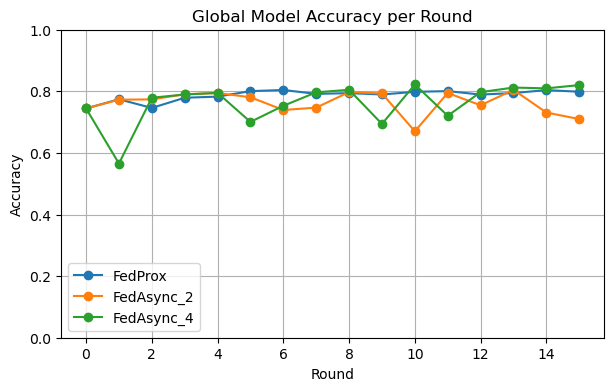

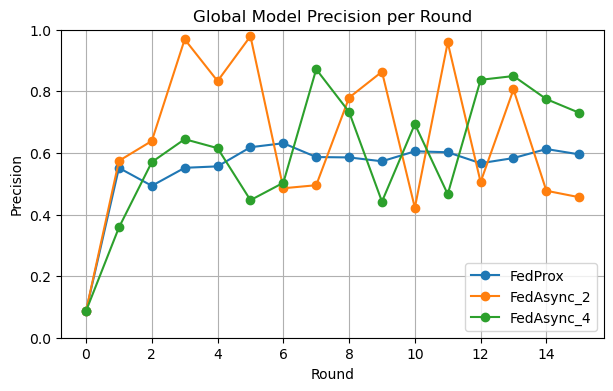

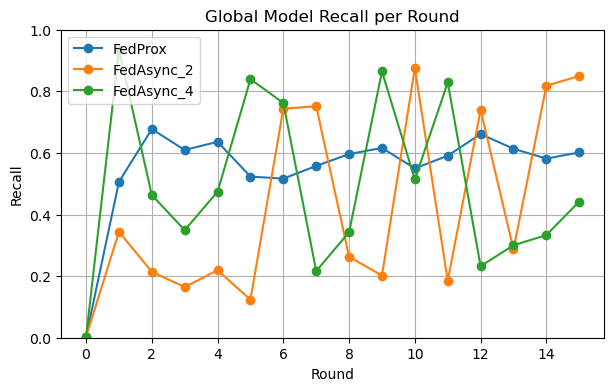

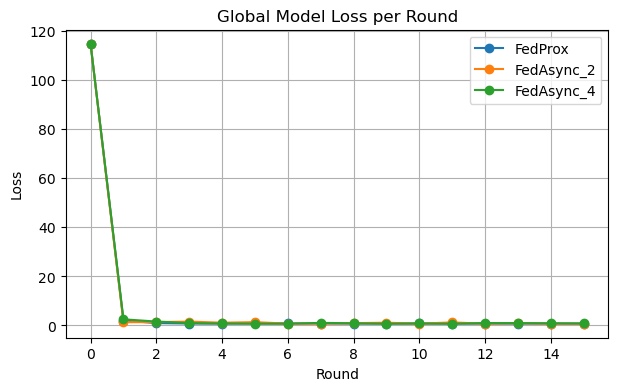

In [539]:
fig_acc, ax_acc = plt.subplots(figsize=(7,4)) # Create a new figure for accuracy
for name, history in histories.items():
    accs = [metric[1] for metric in history.metrics_centralized["accuracy"]]
    rounds = [metric[0] for metric in history.metrics_centralized["accuracy"]]
    ax_acc.plot(rounds, accs, marker='o', linestyle='-', label=name)

ax_acc.set_title("Global Model Accuracy per Round")
ax_acc.set_xlabel("Round")
ax_acc.set_ylabel("Accuracy")
ax_acc.grid(True)
ax_acc.legend()
ax_acc.set_ylim(0, 1)
# plt.tight_layout() # Adjust layout for the current figure

# --- Plot 2: Precision ---
fig_prec, ax_prec = plt.subplots(figsize=(7, 4)) # Create a new figure for precision
for name, history in histories.items():
    precs = [metric[1] for metric in history.metrics_centralized["precision"]]
    rounds = [metric[0] for metric in history.metrics_centralized["precision"]]
    ax_prec.plot(rounds, precs, marker='o', linestyle='-', label=name)

ax_prec.set_title("Global Model Precision per Round")
ax_prec.set_xlabel("Round")
ax_prec.set_ylabel("Precision")
ax_prec.grid(True)
ax_prec.legend()
ax_prec.set_ylim(0, 1)
# plt.tight_layout() # Adjust layout for the current figure

# --- Plot 3: Recall ---
fig_rec, ax_rec = plt.subplots(figsize=(7, 4)) # Create a new figure for recall
for name, history in histories.items():
    recs = [metric[1] for metric in history.metrics_centralized["recall"]]
    rounds = [metric[0] for metric in history.metrics_centralized["recall"]]
    ax_rec.plot(rounds, recs, marker='o', linestyle='-', label=name)

ax_rec.set_title("Global Model Recall per Round")
ax_rec.set_xlabel("Round")
ax_rec.set_ylabel("Recall")
ax_rec.grid(True)
ax_rec.legend()
ax_rec.set_ylim(0, 1)
# plt.tight_layout() # Adjust layout for the current figure

fig_loss, ax_loss = plt.subplots(figsize=(7, 4)) # Create a new figure for recall
for name, history in histories.items():
    loss = [metric[1] for metric in history.metrics_centralized["loss"]]
    rounds = [metric[0] for metric in history.metrics_centralized["loss"]]
    ax_loss.plot(rounds, loss, marker='o', linestyle='-', label=name)

ax_loss.set_title("Global Model Loss per Round")
ax_loss.set_xlabel("Round")
ax_loss.set_ylabel("Loss")
ax_loss.grid(True)
ax_loss.legend()
# Display all created figures
plt.show()